# Introduction

This is an example notebook for testing noise filtering methods on Birds Dataset.
The focus is to start to explore some techniques of preprocessing that can be used to improve bird detection models.
The problem is that the Cornell Birdcall Identification Dataset have many sounds of low quality, with high level background sounds and noises. Thus, I believe that applying some filtering method for noise reduction can improve the classification task.

Common detection pipelines consist of:
* Preprocessing: To read a audio file, optionally apply signal filtering techniques, and perform feature extraction (e.g. mfccs);
* Trainning a classification model based on features (TO DO);
* Evaluation: To test the trainned models over a split of the dataset (TO DO).

The preprocess methods you can see here are:
* Traditional log mel-spectogram;
* High-Pass Filtering: Reduces low frequencies, once bird sound are commonly present on high frequencies;
* Per-channel energy normalization (PCEN): Technique for automatic gain control, followed by nonlinear compression;
* Spectral Gating: Common strategy for denoising music by gating the signal only on high level sounds.

Please, use this notebook as a didactical one. 
If you enjoy it, please, leave your upvote and comments.

Thanks!

In [2]:
pip install librosa


   ---------------------------------------- 0.0/260.1 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/260.1 kB 640.0 kB/s eta 0:00:01
   ---- ---------------------------------- 30.7/260.1 kB 640.0 kB/s eta 0:00:01
   ---------- ---------------------------- 71.7/260.1 kB 558.5 kB/s eta 0:00:01
   ------------- ------------------------- 92.2/260.1 kB 581.0 kB/s eta 0:00:01
   ------------- ------------------------- 92.2/260.1 kB 581.0 kB/s eta 0:00:01
   ---------------------- --------------- 153.6/260.1 kB 573.4 kB/s eta 0:00:01
   ----------------------------- -------- 204.8/260.1 kB 621.6 kB/s eta 0:00:01
   ----------------------------- -------- 204.8/260.1 kB 621.6 kB/s eta 0:00:01
   -------------------------------------- 260.1/260.1 kB 613.9 kB/s eta 0:00:00
   ---------------------------------------- 0.0/75.1 kB ? eta -:--:--
   ---------------- ----------------------- 30.7/75.1 kB ? eta -:--:--
   ---------------------------------------- 75.1/75.1 kB 1.0 MB/s et


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: C:\Users\KARUNESH SRIVASTAVA\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Imports

In [3]:
# feature extractoring and preprocessing data
import librosa
import librosa.display
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from pathlib import Path
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

import csv
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
#Reports
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


# Preprocessing methods

## Reading some audio samples

Let's see some preprocessing techniques over the example_test_audio dataset.

In [4]:
sr = 16000
e_file1 = 'F01_Session1_0001.wav'
e_file2 = 'M01_Session1_0005.wav'

# 10 seconds of each file
y1,sr = librosa.load(e_file1, mono=True, sr=sr, offset=0, duration=10)
y2,sr = librosa.load(e_file2, mono=True, sr=sr, offset=0, duration=12)

Listen to them!

In [5]:
from IPython.display import Audio, IFrame, display

display(Audio(y1,rate=sr))
display(Audio(y2,rate=sr))

As you can hear, the first audio presents a high level background noise, and birds seems far from the mic. In the second audio, bird sounds are much more distinguished from the other noises. We can say that the second audio presents a better SNR (signal-noise ratio).

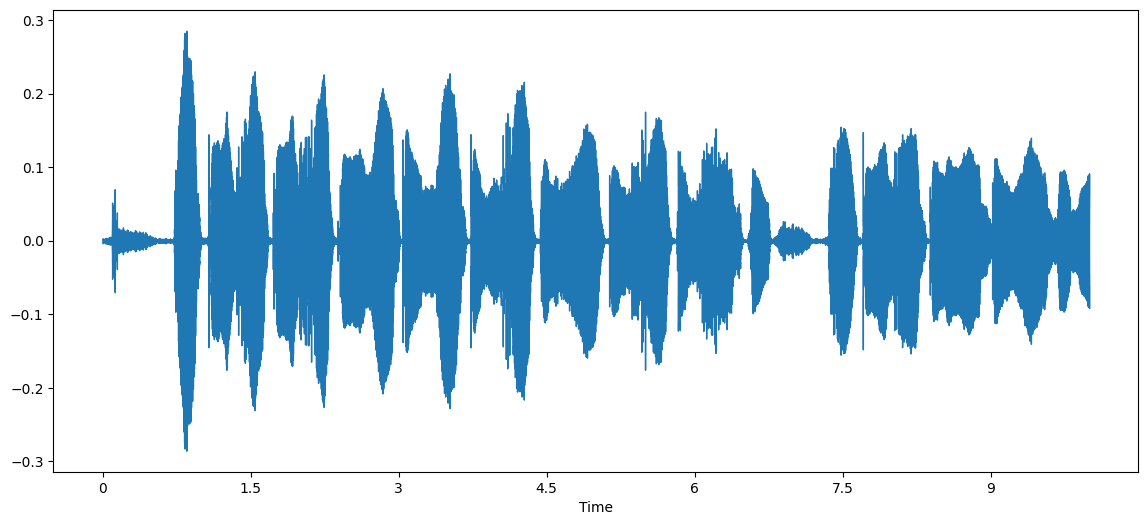

In [7]:
librosa.display.waveshow(y1,sr=sr, x_axis='time');

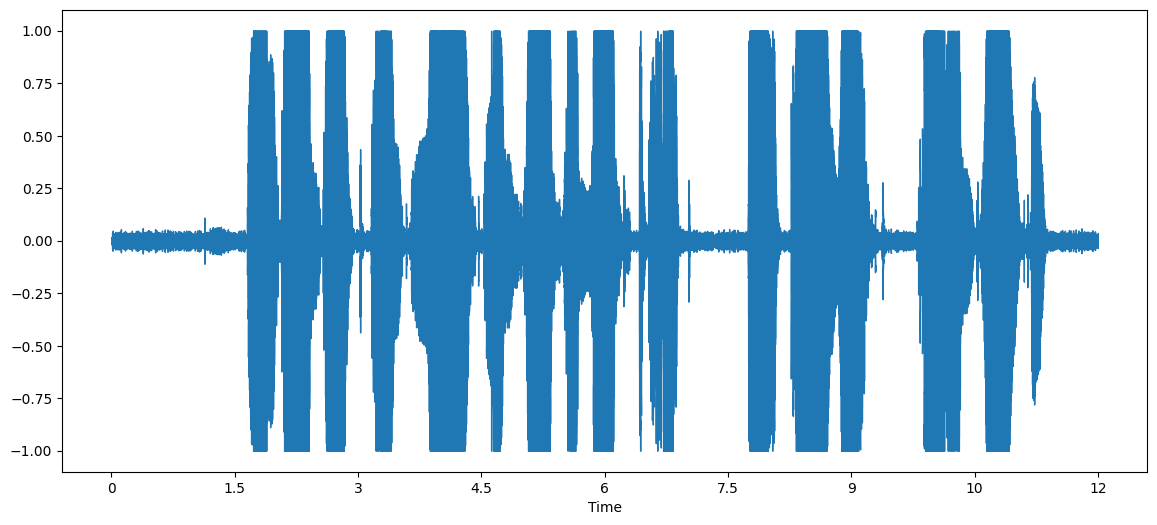

In [8]:
librosa.display.waveshow(y2,sr=sr, x_axis='time');

## Logmel-spectogram

A very common preprocessing technique in audio detection applications is to transform audios to its log mel-spectogram representation.

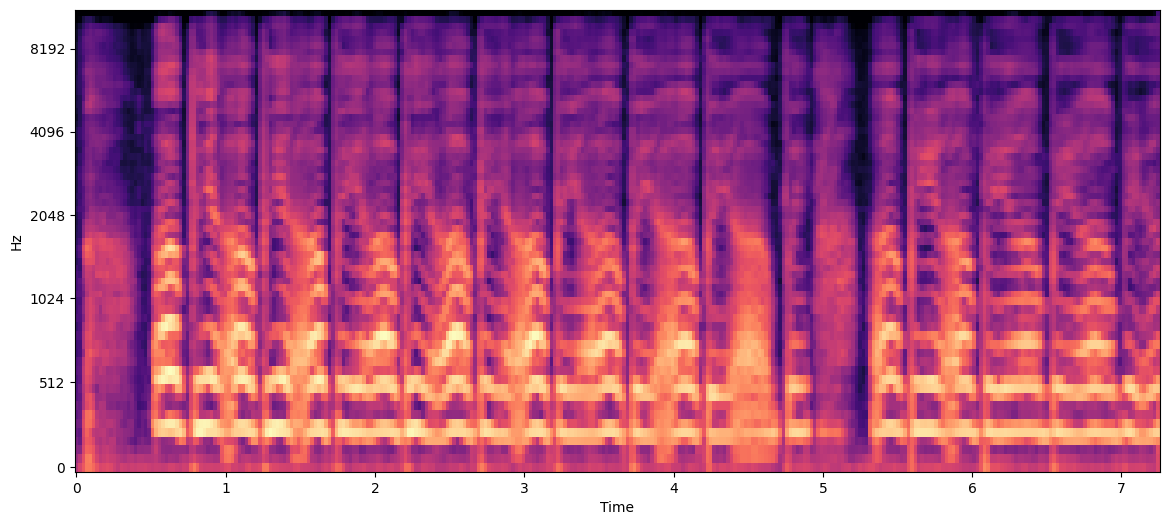

In [9]:
S1 = librosa.feature.melspectrogram(y=y1, sr=sr, n_mels=64)
D1 = librosa.power_to_db(S1, ref=np.max)
librosa.display.specshow(D1, x_axis='time', y_axis='mel');

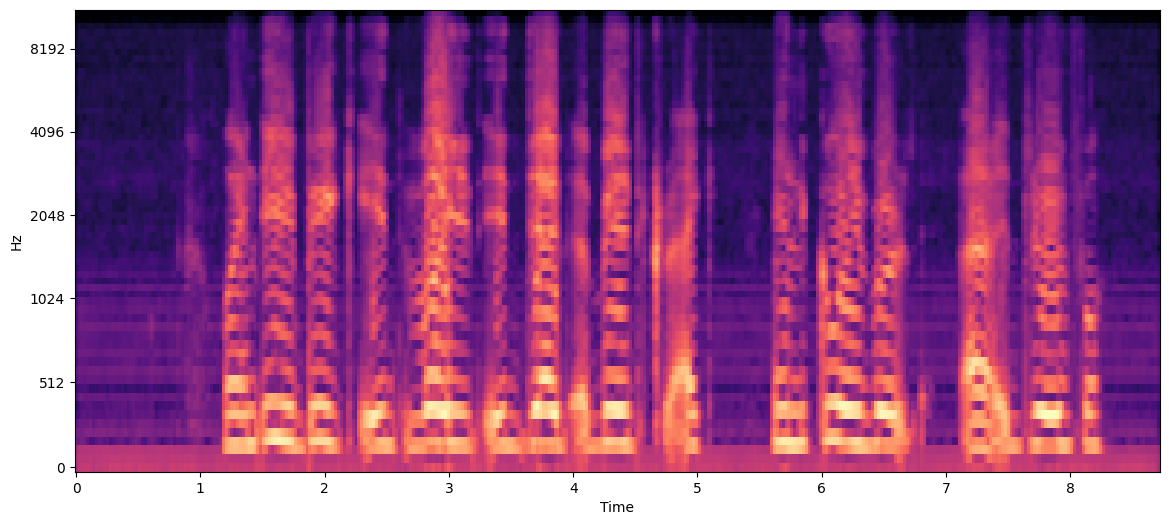

In [10]:
S2 = librosa.feature.melspectrogram(y=y2, sr=sr, n_mels=64)
D2 = librosa.power_to_db(S2, ref=np.max)
librosa.display.specshow(D2, x_axis='time', y_axis='mel');

## Filtering low-frequencies

low frequencies do not contribute to sounds, a first idea is to remove these low frequencies. A high pass filter helps in this task.

In [12]:
from scipy import signal
import random


def f_high(y,sr):
    b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
    yf = signal.lfilter(b,a,y)
    return yf


In [13]:
yf1 = f_high(y1, sr)
yf2 = f_high(y2, sr)

Let's see...

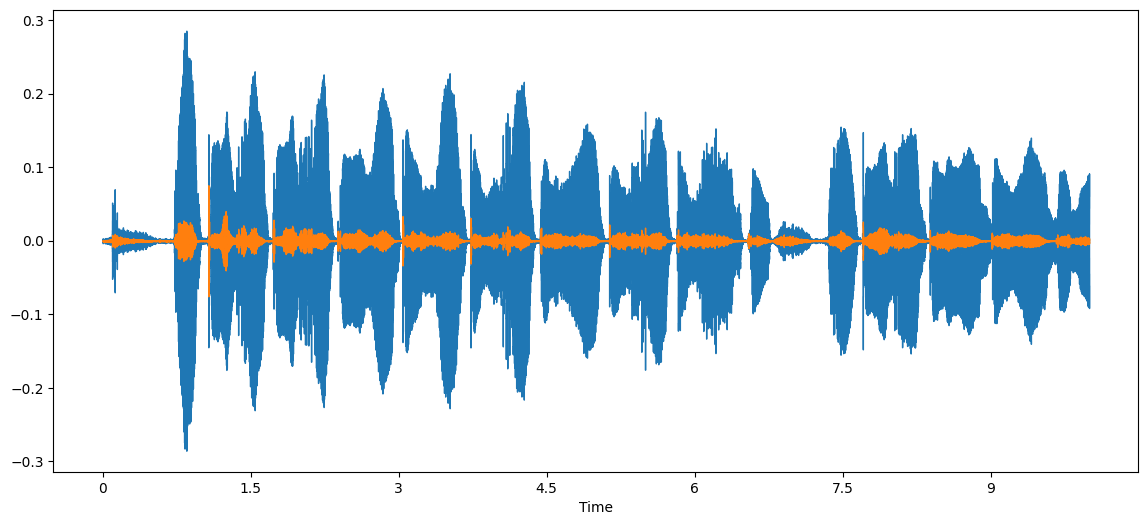

In [15]:
librosa.display.waveshow(y1,sr=sr, x_axis='time');
librosa.display.waveshow(yf1,sr=sr, x_axis='time');

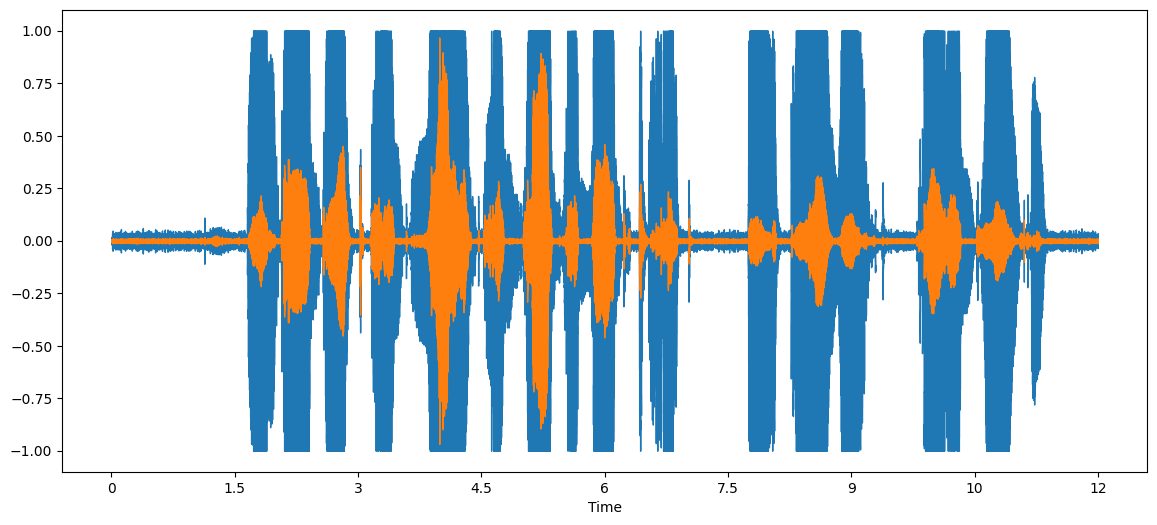

In [16]:
librosa.display.waveshow(y2,sr=sr, x_axis='time');
librosa.display.waveshow(yf2,sr=sr, x_axis='time');

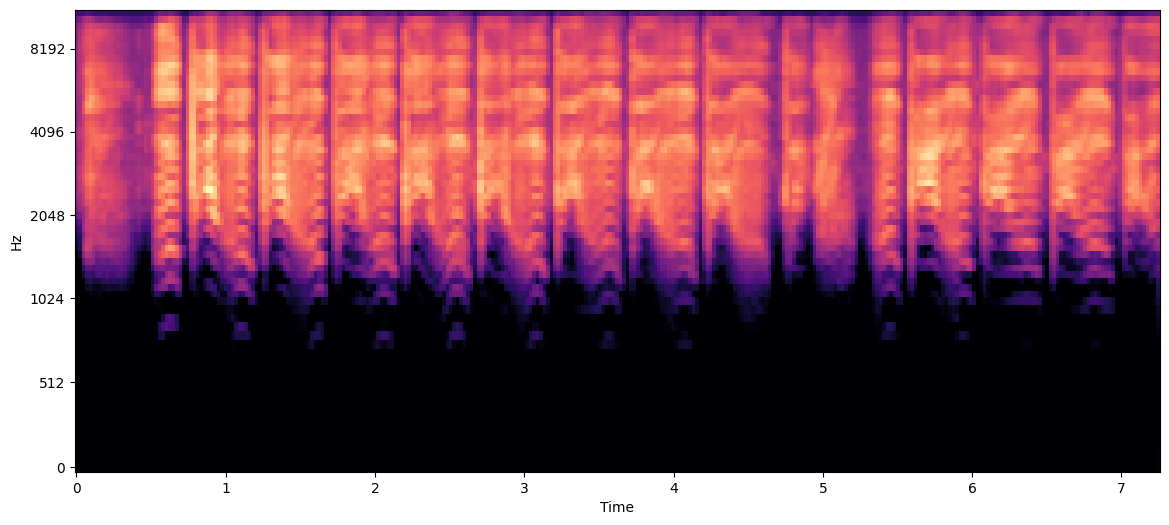

In [17]:
Sf1 = librosa.feature.melspectrogram(y=yf1, sr=sr, n_mels=64)
Df1 = librosa.power_to_db(Sf1, ref=np.max)
librosa.display.specshow(Df1, x_axis='time', y_axis='mel');

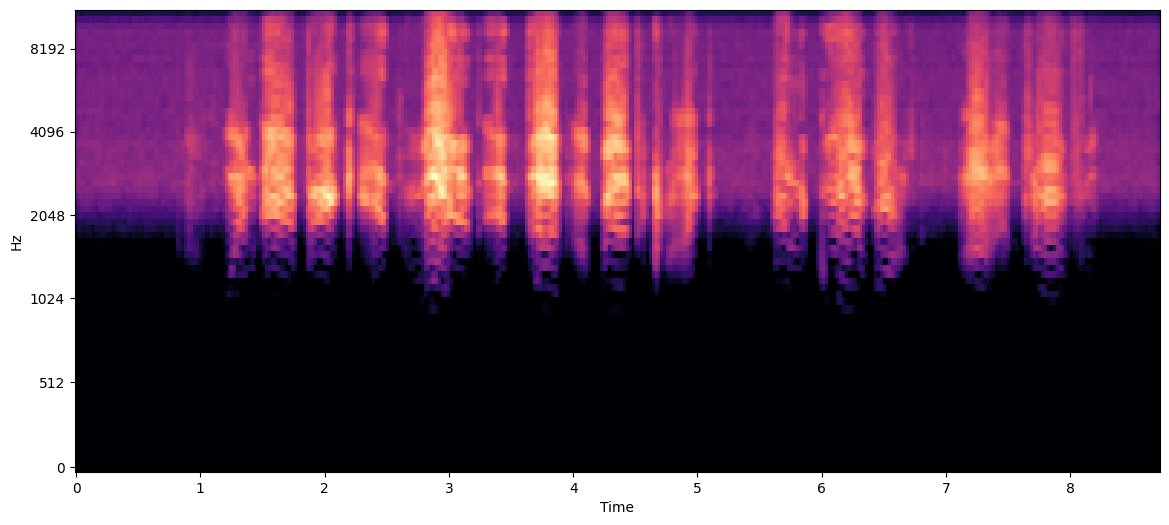

In [18]:
Sf2 = librosa.feature.melspectrogram(y=yf2, sr=sr, n_mels=64)
Df2 = librosa.power_to_db(Sf2, ref=np.max)
librosa.display.specshow(Df2, x_axis='time', y_axis='mel');

In [19]:
display(Audio(yf1,rate=sr))
display(Audio(yf2,rate=sr))

Uowwwww! It looks very promising!
This method does not eliminate all background, but the bird signal shapes are much more visible in the spectograms.
This method works on time-frequency representarions of the sounds, so I perform signal reconstitution from spectogram to audio to gives us a good idea on how it worked. This recostitution is not perfect, some artefacts are inserted.

## Spectral Gating

This is also a technique for noise reduction based on gates that monitor audio level. It is commonly used in music industry, and present in tools like Audacity (https://wiki.audacityteam.org/wiki/How_Audacity_Noise_Reduction_Works).
I reproduced here the code made available by Tim Sainburg in his github (https://github.com/timsainb/noisereduce).

In [45]:
import time
from datetime import timedelta as td


def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length=hop_length, win_length=win_length)


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()

def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False,
):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose:
        start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    #print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal

In [46]:
noise1 = yf1[5*sr:6*sr]
yg1 = removeNoise(audio_clip=yf1, noise_clip=noise1,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False)
noise2 = yf2[0:1*sr]
yg2 = removeNoise(audio_clip=yf2, noise_clip=noise2,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=2.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False)

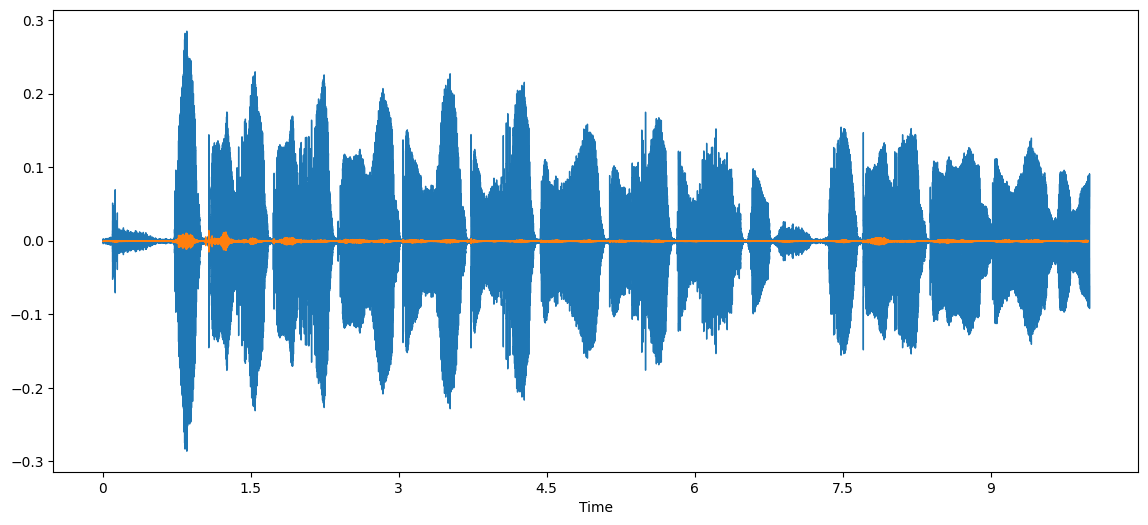

In [48]:
librosa.display.waveshow(y1,sr=sr, x_axis='time');
librosa.display.waveshow(yg1,sr=sr, x_axis='time');

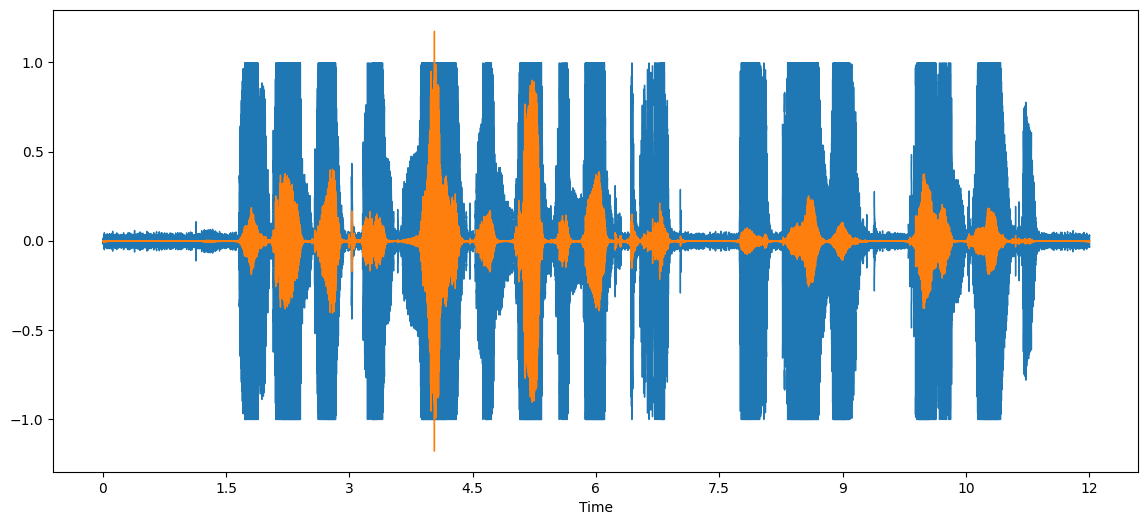

In [49]:
librosa.display.waveshow(y2,sr=sr, x_axis='time');
librosa.display.waveshow(yg2,sr=sr, x_axis='time');

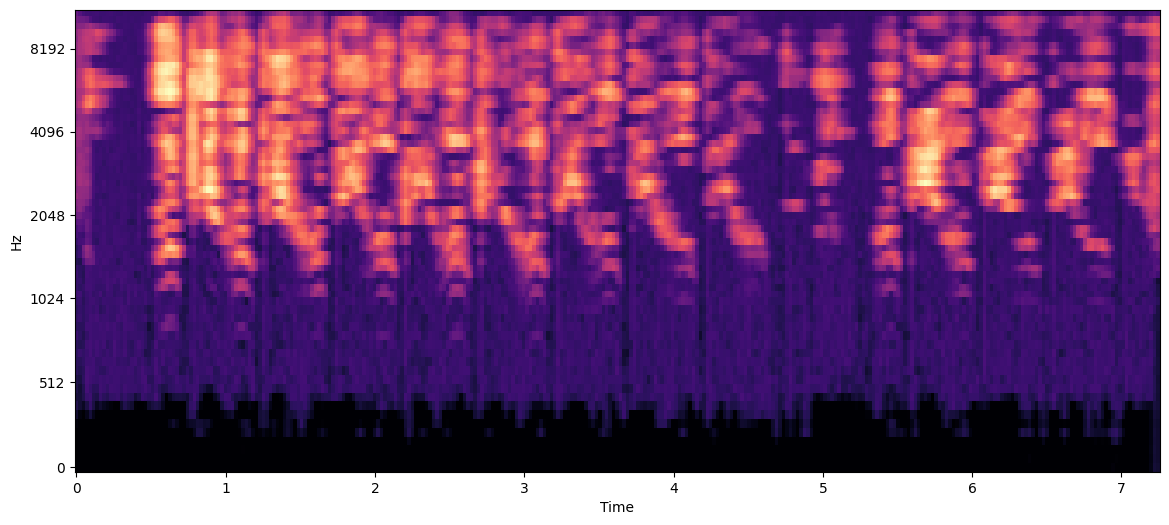

In [50]:
Sg1 = librosa.feature.melspectrogram(y=yg1, sr=sr, n_mels=64)
Dg1 = librosa.power_to_db(Sg1, ref=np.max)
librosa.display.specshow(Dg1, x_axis='time', y_axis='mel');

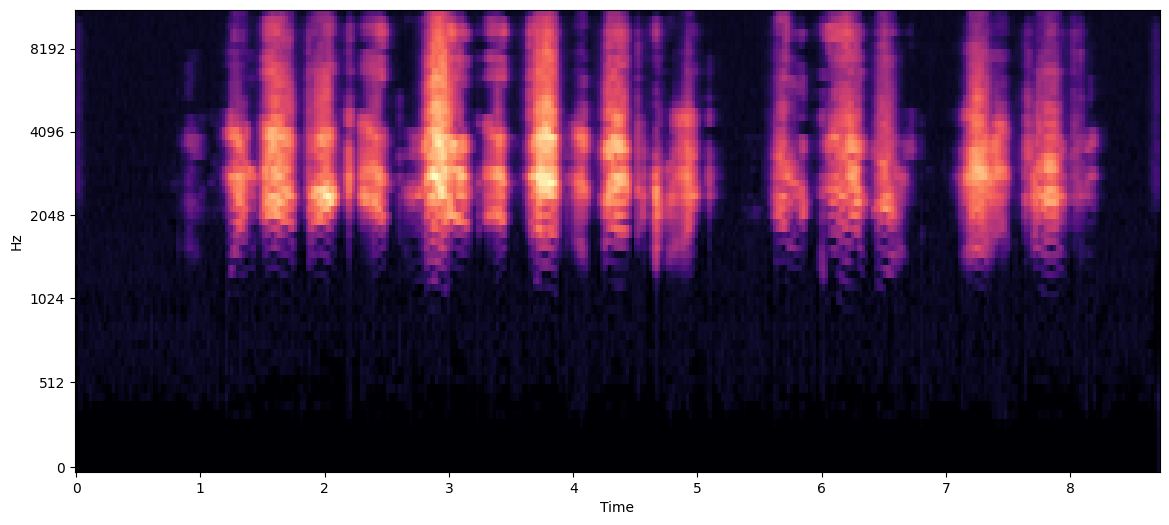

In [51]:
Sg2 = librosa.feature.melspectrogram(y=yg2, sr=sr, n_mels=64)
Dg2 = librosa.power_to_db(Sg2, ref=np.max)
librosa.display.specshow(Dg2, x_axis='time', y_axis='mel');

In [52]:
display(Audio(yg1,rate=sr))
display(Audio(yg2,rate=sr))

In [ ]:
import librosa
import numpy as np
import soundfile as sf

def normalize_audio(audio, target_level=-20):
    """
    Normalize the amplitude of an audio signal to a target level in dB.

    Parameters:
    audio (numpy.ndarray): The input audio signal.
    target_level (float): The target level in dBFS (decibels relative to full scale).

    Returns:
    numpy.ndarray: The normalized audio signal.
    """
    # Calculate the RMS (Root Mean Square) level of the audio
    rms = np.sqrt(np.mean(audio**2))
    
    # Convert RMS level to dB
    current_level_db = 20 * np.log10(rms)
    
    # Calculate the scaling factor to adjust the audio to the target level
    scaling_factor = 10 ** ((target_level - current_level_db) / 20)
    
    # Apply the scaling factor to normalize the audio
    normalized_audio = audio * scaling_factor
    
    return normalized_audio

def process_audio(file_path, output_path, target_level=-20):
    """
    Load, normalize, and save an audio file.

    Parameters:
    file_path (str): The path to the input audio file.
    output_path (str): The path to save the normalized audio.
    target_level (float): The target normalization level in dBFS.
    """
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)
    
    # Normalize the audio to the target level
    normalized_audio = normalize_audio(audio, target_level=target_level)
    
    # Save the normalized audio back to a file
    sf.write(output_path, normalized_audio, sr)
    print(f"Normalized audio saved to {output_path}.")

# Paths for the two audio files
audio_path1 = 'your_audio_file1.wav'
audio_path2 = 'your_audio_file2.wav'

# Output paths for the normalized audio files
output_path1 = 'normalized_audio1.wav'
output_path2 = 'normalized_audio2.wav'

# Normalize and save the two audio files
process_audio(audio_path1, output_path1, target_level=-20)
process_audio(audio_path2, output_path2, target_level=-20)
